In [1]:
import numpy as np
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import *

In [27]:
class VQA: 

    def __init__(self, qubits, shots):
        self.qubits = qubits
        self.shots = shots

class VQSD(VQA):

    def __init__(self, qubits, shots):
        super().__init__(qubits, shots)
        #self.depth = depth

    def run(self, param = None):
        if param == None:
            param = []
            d = 1
            L = self.qubits + 2*(self.qubits - 1)*d
            for i in range(L):
                param.append(i)
        #print(param)
        
        def test_prep(param):
            for i in range(2*self.qubits):
                qml.Hadamard(i)
        
        def cost_cirq(param):
            for i in range(self.qubits):
                qml.CNOT(wires = [i,i+self.qubits])


        def Ansatz(param):
            qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits))
            qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits, 2*self.qubits))

        dev = qml.device("default.qubit", wires = 2*self.qubits, shots = self.shots)
        @qml.qnode(dev, interface="autograd")
        def vqsd(param):
            test_prep(param)
            Ansatz(param)
            cost_cirq(param)
            return qml.probs(wires = [i for i in range(self.qubits, 2*self.qubits)])

        #drawer = qml.draw(vqsd)
        #print(drawer((param)))

        def output(param):
            return 1-vqsd(param)[0] 

        return (output(param))

    def eval_readout(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(1.57)


        def opt_test_prep(param):
            for i in range(self.qubits):
                qml.Hadamard(i)
                
        def Ansatz(param):
            qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits))

        dev2 = qml.device("default.mixed", wires = self.qubits, shots = self.shots)
        @qml.qnode(dev2, interface = "autograd")
        def eval_read(param):
            opt_test_prep(param)
            Ansatz(param)
            return qml.probs()
        
        #drawer = qml.draw(eval_read)
        #print(drawer((param)))

        return (eval_read(param))

    def opt(self, depth, step):
        #t = []
        angle = []
        diag = []
        Ev = []
        Ev0 = []
        Ev1 = []
        #theta = 0
        #d = 1
        #L = self.qubits + 2*(self.qubits - 1)*depth

        #for i in range(L):
            #t.append(0)
        #    t.append(2*(np.pi)*(np.random.uniform()))
        #theta = np.array(t, requires_grad=True)

        shapes = qml.SimplifiedTwoDesign.shape(n_layers=depth, n_wires=self.qubits)
        theta = [np.random.random(size=shape) for shape in shapes]

        #for i in range(2**self.qubits):
        #    Ev.append(self.eval_readout(theta)[i])

        angle = [theta]
        diag = [self.run(theta)]
        Ev = [self.eval_readout(theta)]
        Ev0 = [self.eval_readout(theta)[1]]
        Ev1 = [self.eval_readout(theta)[0]]

        opt = qml.GradientDescentOptimizer(stepsize=step)
        max_iterations = 200
        conv_tol = 1e-03
        start_time = time.time()

        for n in range(max_iterations):
            theta, prev_diag = opt.step_and_cost(self.run, theta)

            diag.append(self.run(theta))
            angle.append(theta)

            #Ev = np.vstack(Ev, [self.eval_readout(theta)])
            
            Ev0.append(self.eval_readout(theta)[1])
            Ev1.append(self.eval_readout(theta)[0])

            #conv = np.abs(diag[-1])

            #if n % 40 ==0:
                

            if n % 10 == 0:
                print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Value0 = {Ev0[-1]}, Eigen_Value1 = {Ev1[-1]}")
            
            
            if n == max_iterations:
                print("\n"f"Max iterations = {max_iterations}")
                break
    
            #if conv <= conv_tol:
            #    max_iterations = n
            #    print("\n"f"Max iterations = {n}")
            #    break
        print("\n" f"Optimization runtime = {time.time() - start_time}s")
        print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
        print("\n" f"Eigenvalues are: {self.eval_readout(angle[-1])}")
        #opt_angle = angle[-1]

        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(12)
        
        

        plt.plot(range(len(diag)), diag, "k", ls = "solid")
        #for i in range(len(Ev[:,0])):
            #plt.plot(range(len(diag)), Ev[i,0], "r", ls="dashed")
            #plt.plot(range(len(diag)), Ev[i,1], "r", ls="dashed")
            #plt.plot(range(len(diag)), Ev[i,2], "b", ls="dashed")
        plt.plot(range(len(diag)), Ev0, "r", ls="dashed")
        plt.plot(range(len(diag)), Ev1, "b", ls="dashed")
#plt.set_xlabel("Optimization step", fontsize=13)
#plt.set_ylabel("Diagonality", fontsize=13)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()

        #return Ev

Step = 0,  Diagonality = 0.45000000, Eigen_Value0 = 0.64, Eigen_Value1 = 0.28
Step = 10,  Diagonality = 0.48000000, Eigen_Value0 = 0.69, Eigen_Value1 = 0.35
Step = 20,  Diagonality = 0.39000000, Eigen_Value0 = 0.64, Eigen_Value1 = 0.24
Step = 30,  Diagonality = 0.49000000, Eigen_Value0 = 0.74, Eigen_Value1 = 0.26
Step = 40,  Diagonality = 0.48000000, Eigen_Value0 = 0.63, Eigen_Value1 = 0.38
Step = 50,  Diagonality = 0.44000000, Eigen_Value0 = 0.73, Eigen_Value1 = 0.35
Step = 60,  Diagonality = 0.40000000, Eigen_Value0 = 0.7, Eigen_Value1 = 0.32
Step = 70,  Diagonality = 0.38000000, Eigen_Value0 = 0.62, Eigen_Value1 = 0.4
Step = 80,  Diagonality = 0.37000000, Eigen_Value0 = 0.64, Eigen_Value1 = 0.24
Step = 90,  Diagonality = 0.40000000, Eigen_Value0 = 0.67, Eigen_Value1 = 0.29
Step = 100,  Diagonality = 0.41000000, Eigen_Value0 = 0.72, Eigen_Value1 = 0.27
Step = 110,  Diagonality = 0.41000000, Eigen_Value0 = 0.63, Eigen_Value1 = 0.39
Step = 120,  Diagonality = 0.47000000, Eigen_Value0 =

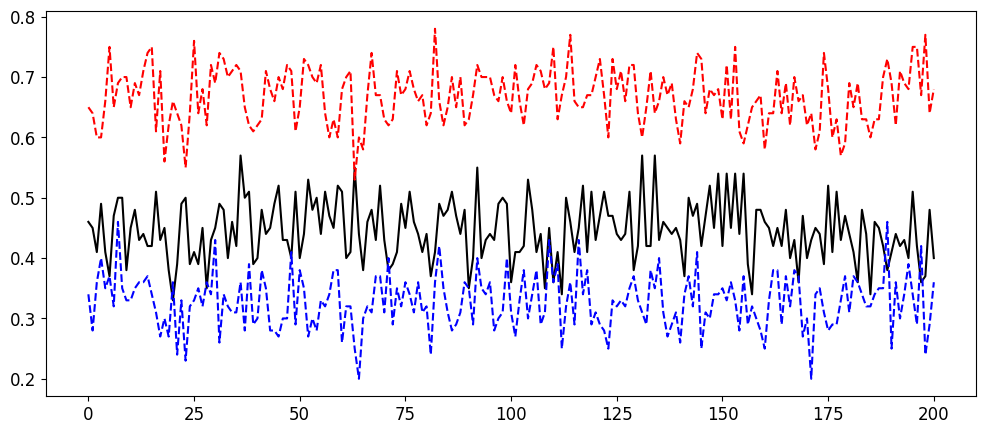

In [35]:
v = VQSD(1, 100)
v.opt(1, 0.2)

In [25]:
qubits = 1
depth = 1

shapes = qml.SimplifiedTwoDesign.shape(n_layers=depth, n_wires=qubits)
#param = [np.random.random(size=shape) for shape in shapes]
param = [np.array([np.pi/2], requires_grad = True) for shape in shapes]
#def Ansatz(param):
#    qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(qubits))
#    qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(o, qubits+o))
param
#shapes
#drawer = qml.draw(Ansatz)
#print(drawer(param))
#v.run(param)

[tensor([1.57079633], requires_grad=True),
 tensor([1.57079633], requires_grad=True)]

In [88]:
param

[tensor([0.75325534], requires_grad=True),
 tensor([0.21657151], requires_grad=True)]

In [79]:
qubits =3
depth = 2
o = 3

shapes = qml.SimplifiedTwoDesign.shape(n_layers=depth, n_wires=qubits)
for shape in shapes:
    param1 = np.random.random(size=shape)
param1

tensor([[[0.83869686, 0.53716763],
         [0.18984441, 0.27664956]],

        [[0.11431359, 0.82102168],
         [0.86474666, 0.44887352]]], requires_grad=True)

In [60]:
v = VQSD(5, 100)
v.run()

0: ──H──RZ(0.00)──RX(1.57)─╭●──RZ(5.00)──RX(1.57)─────────────────────────╭●─────────────┤       
1: ──H──RZ(1.00)──RX(1.57)─╰X──RZ(6.00)──RX(1.57)─╭●──RZ(9.00)───RX(1.57)─│──╭●──────────┤       
2: ──H──RZ(2.00)──RX(1.57)─╭●──RZ(7.00)──RX(1.57)─╰X──RZ(10.00)──RX(1.57)─│──│──╭●───────┤       
3: ──H──RZ(3.00)──RX(1.57)─╰X──RZ(8.00)──RX(1.57)─╭●──RZ(11.00)──RX(1.57)─│──│──│──╭●────┤       
4: ──H──RZ(4.00)──RX(1.57)────────────────────────╰X──RZ(12.00)──RX(1.57)─│──│──│──│──╭●─┤       
5: ──H──RZ(0.00)──RX(1.57)─╭●──RZ(5.00)──RX(1.57)─────────────────────────╰X─│──│──│──│──┤ ╭Probs
6: ──H──RZ(1.00)──RX(1.57)─╰X──RZ(6.00)──RX(1.57)─╭●──RZ(9.00)───RX(1.57)────╰X─│──│──│──┤ ├Probs
7: ──H──RZ(2.00)──RX(1.57)─╭●──RZ(7.00)──RX(1.57)─╰X──RZ(10.00)──RX(1.57)───────╰X─│──│──┤ ├Probs
8: ──H──RZ(3.00)──RX(1.57)─╰X──RZ(8.00)──RX(1.57)─╭●──RZ(11.00)──RX(1.57)──────────╰X─│──┤ ├Probs
9: ──H──RZ(4.00)──RX(1.57)────────────────────────╰X──RZ(12.00)──RX(1.57)─────────────╰X─┤ ╰Probs


0.9299999999999999

In [48]:
shapes = qml.SimplifiedTwoDesign.shape(n_layers=1, n_wires=4)
weights = [np.random.random(size=shape) for shape in shapes]
print(shapes)
print(weights)

[(4,), (1, 3, 2)]
[tensor([0.8458583 , 0.09987059, 0.41951164, 0.70022958], requires_grad=True), tensor([[[0.81132048, 0.22352339],
         [0.67625845, 0.59846879],
         [0.56141928, 0.69499118]]], requires_grad=True)]


In [51]:
weights[1]

tensor([[[0.81132048, 0.22352339],
         [0.67625845, 0.59846879],
         [0.56141928, 0.69499118]]], requires_grad=True)

In [57]:
v.run([4.7])

0.0

In [72]:
v = VQSD(1, 100)
v.run()

TypeError: VQA.__init__() missing 1 required positional argument: 'shots'

Step = 0,  Diagonality = 0.06000000, Eigen_Value0 = 0.97, Eigen_Value1 = 0.06
Step = 10,  Diagonality = 0.00000000, Eigen_Value0 = 1.0, Eigen_Value1 = 0.01
Step = 20,  Diagonality = 0.00000000, Eigen_Value0 = 1.0, Eigen_Value1 = 0.0
Step = 30,  Diagonality = 0.00000000, Eigen_Value0 = 1.0, Eigen_Value1 = 0.0
Step = 40,  Diagonality = 0.00000000, Eigen_Value0 = 1.0, Eigen_Value1 = 0.0

Optimization runtime = 0.7047276496887207s

Optimal value of the circuit parameter = [4.69276352]

Eigenvalues are: [0. 1.]


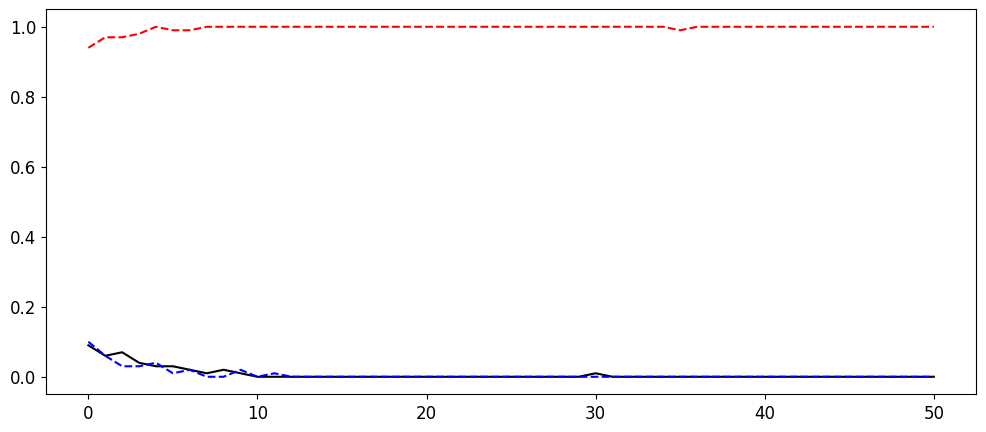

In [52]:
v = VQSD(1, 100)
v.opt()

Step = 0,  Diagonality = 0.65000000, Eigen_Value0 = 0.16, Eigen_Value1 = 0.36
Step = 10,  Diagonality = 0.50000000, Eigen_Value0 = 0.07, Eigen_Value1 = 0.36
Step = 20,  Diagonality = 0.43000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.48
Step = 30,  Diagonality = 0.55000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.5
Step = 40,  Diagonality = 0.42000000, Eigen_Value0 = 0.01, Eigen_Value1 = 0.55
Step = 50,  Diagonality = 0.59000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.45
Step = 60,  Diagonality = 0.57000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.5
Step = 70,  Diagonality = 0.51000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.5
Step = 80,  Diagonality = 0.45000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.49
Step = 90,  Diagonality = 0.44000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.55
Step = 100,  Diagonality = 0.41000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.45
Step = 110,  Diagonality = 0.52000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.48
Step = 120,  Diagonality = 0.56000000, Eigen_Value0 = 0.0, Eige

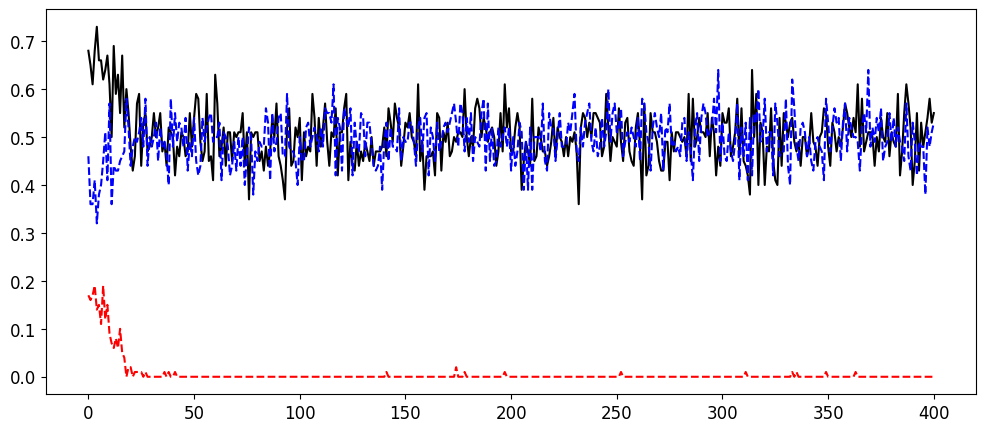

[array([0.29, 0.25, 0.12, 0.34])]

In [27]:
v = VQSD(2, 100)
v.opt()

Step = 0,  Diagonality = 0.82000000, Eigen_Value0 = 0.03, Eigen_Value1 = 0.21
Step = 10,  Diagonality = 0.87000000, Eigen_Value0 = 0.08, Eigen_Value1 = 0.3
Step = 20,  Diagonality = 0.78000000, Eigen_Value0 = 0.01, Eigen_Value1 = 0.22
Step = 30,  Diagonality = 0.78000000, Eigen_Value0 = 0.03, Eigen_Value1 = 0.27
Step = 40,  Diagonality = 0.81000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.24
Step = 50,  Diagonality = 0.86000000, Eigen_Value0 = 0.04, Eigen_Value1 = 0.31
Step = 60,  Diagonality = 0.68000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.27
Step = 70,  Diagonality = 0.78000000, Eigen_Value0 = 0.02, Eigen_Value1 = 0.25
Step = 80,  Diagonality = 0.73000000, Eigen_Value0 = 0.01, Eigen_Value1 = 0.3
Step = 90,  Diagonality = 0.80000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.28
Step = 100,  Diagonality = 0.75000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.33
Step = 110,  Diagonality = 0.80000000, Eigen_Value0 = 0.0, Eigen_Value1 = 0.38
Step = 120,  Diagonality = 0.74000000, Eigen_Value0 = 0.0,

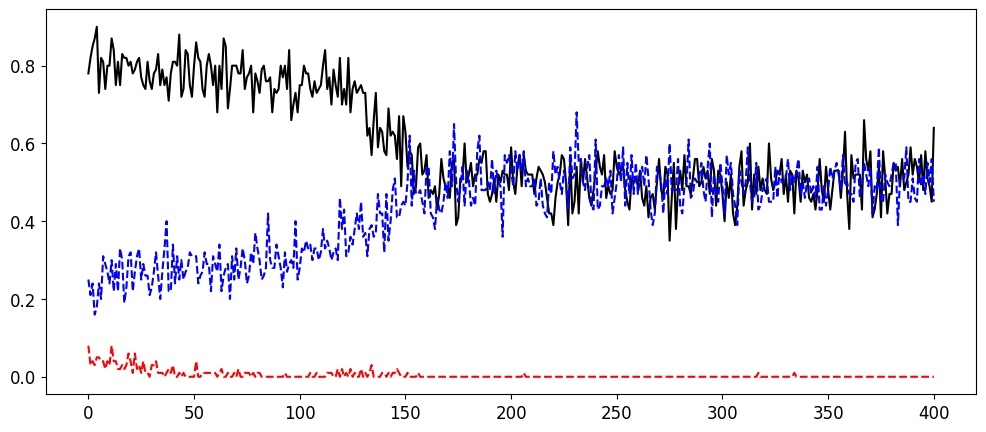

[array([0.21, 0.07, 0.1 , 0.11, 0.27, 0.05, 0.04, 0.15])]

In [19]:
v = VQSD(3, 100)
v.opt()

In [205]:
a = [1, 2, 3]
b = [4, 5, 6]
d = [7, 8, 9]
c = np.vstack((c, d))
c
#c.stack(d)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
        [7, 8, 9]], requires_grad=True)

In [207]:
len(c[:,0])

4

In [ ]:
        #def ansatz(param):
            
            #if len(param) == 1:
            #     rot(param[0], wires = 0)
            #     rot(param[0], wires = 1)

            #elseif len(param) % 2:

            #for i in range(len(param)):
            #    rot_ent
                
            #    qml.RZ(param[i], wires = i)
            #    qml.RZ(param[i], wires = i+len(param))
            #    qml.RX(np.pi/2, wires = i)
            #    qml.RX(np.pi/2, wires = i+len(param))

In [11]:
param = []
d = 1
n_wires = 2
half = n_wires/2
L = n_wires + 2*(n_wires - 1)*d
for i in range(L):
    param.append(i)

v.run(param)

0: ──H──RZ(0.00)──RX(1.57)─╭●──RZ(2.00)──RX(1.57)─╭●──────────┤       
1: ──H──RZ(1.00)──RX(1.57)─╰X──RZ(3.00)──RX(1.57)─│──╭●───────┤       
2: ──H────────────────────────────────────────────│──│──╭●────┤       
3: ──H────────────────────────────────────────────│──│──│──╭●─┤       
4: ──H────────────────────────────────────────────╰X─│──│──│──┤ ╭Probs
5: ──H───────────────────────────────────────────────╰X─│──│──┤ ├Probs
6: ──H──────────────────────────────────────────────────╰X─│──┤ ├Probs
7: ──H─────────────────────────────────────────────────────╰X─┤ ╰Probs


In [10]:
param

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [137]:
param = [0, 1]
if len(param) == 1:
    print('bitch')

elif len(param) % 2 == 0:
    print('ass hoe')

ass hoe


In [136]:
len(param)

2

In [141]:
import pennylane as qml
from math import pi

n_wires = 3
dev = qml.device('default.qubit', wires=n_wires)

@qml.qnode(dev)

def circuit(init_weights, weights):
    qml.SimplifiedTwoDesign(initial_layer_weights=init_weights, weights=weights, wires=range(n_wires))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_wires)]

init_weights = [np.pi, np.pi, np.pi]
weights_layer1 = [[0., np.pi],
                  [0., np.pi]]
weights_layer2 = [[np.pi, 0.],
                  [np.pi, 0.]]
weights = [weights_layer1, weights_layer2]

drawer = qml.draw(circuit)
print(drawer(init_weights, weights))

0: ─╭SimplifiedTwoDesign─┤  <Z>
1: ─├SimplifiedTwoDesign─┤  <Z>
2: ─╰SimplifiedTwoDesign─┤  <Z>


In [ ]:
        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def rot_ent(theta1, theta2, i):
            rot(theta1, wires = i)
            rot(theta2, wires = i+1)
            qml.CNOT(wires = [i, i+1])

        

        def ansatz(param):    
            if len(param) == 1:
                 rot(param[0], wires = 0)
                 rot(param[0], wires = 1)

            elif len(param) % 2 == 0:
                for i in range(len(param)):
                    rot_ent
                
            #    qml.RZ(param[i], wires = i)
            #    qml.RZ(param[i], wires = i+len(param))
            #    qml.RX(np.pi/2, wires = i)
            #    qml.RX(np.pi/2, wires = i+len(param))

In [1]:
param = []
d = 1
n_wires = 4
half = n_wires/2
L = n_wires + 2*(n_wires - 1)*d
for i in range(L):
    param.append(i)

def rot(theta, i):
    qml.RZ(theta, wires = i)
    qml.RX(np.pi/2, wires = i)

def initial_layer(param):
    for i in range(n_wires):
        rot(param[0], i)


def rot_ent(param, i, j):
    qml.CNOT(wires = [i, i+1])
    rot(param[j], i)
    rot(param[j+1], i+1)

def rot_block(param):
    for i in range(n_wires-1):
        rot_ent(param, 2*i, n_wires + 2*i)
        rot_ent(param, 2*i+1, n_wires + 2*i)

dev = qml.device('default.qubit', wires=n_wires)
@qml.qnode(dev)
def circuit(param):
    for i in range(n_wires):
        rot(param[i], i)
    rot_block(param)
    #rot_ent(param, 0, n_wires)
    #rot_ent(param, 2, n_wires+2)
    #rot_ent(param, 1, n_wires+4)
    return qml.probs()



drawer = qml.draw(circuit)
print(drawer((param)))

NameError: name 'qml' is not defined

In [192]:
param = []
d = 1
n_wires = 4
L = n_wires + 2*(n_wires - 1)*d
for i in range(L):
    param.append(i)

print(param)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [191]:
L = n_wires + 2(n_wires - 1)*d

<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\chopi\AppData\Local\Temp\ipykernel_30772\3886588845.py:1: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  L = n_wires + 2(n_wires - 1)*d


TypeError: 'int' object is not callable

In [196]:
n_wires/2

2.0

In [200]:
param

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]